# WordNetworks

## Configuration

In [1]:
slug = 'Great-Expectations'
db_file = 'Great-Expectations.db'
# vocab_weight = 'tfidf_sum'
vocab_weight = 'tf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

## Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import vsm_stage as vs
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.neighbors import KernelDensity as KDE

## Pragmas

In [3]:
from IPython.display import display, HTML
%matplotlib inline

## Functions

In [4]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

## Import tables from database

In [16]:
with sqlite3.connect(db_file) as db:
    V = pd.read_sql("SELECT * FROM vocab WHERE stop = 0", db, index_col='term_id')
    K = pd.read_sql("SELECT * FROM token WHERE term_id >= 0", db)

In [17]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [7]:
K.head()

,chap_num,para_num,sent_num,token_num,pos,token_str,punc,num,term_str,term_id
0,0,0,0,0,JJ,GREAT,0,0,great,4329
1,0,0,0,1,NNP,EXPECTATIONS,0,0,expectations,3489
2,0,1,0,2,NNP,Edition,0,0,edition,3146
3,0,2,0,0,IN,by,0,0,by,1379
4,0,2,0,1,NNP,Charles,0,0,charles,1572


In [18]:
BOW = vs.get_bow_from_token(K, V)
DTM = vs.bow_to_dtm(BOW)
TF = vs.compute_tf(DTM, V)
TFIDF = vs.compute_tfidf(TF, DTM, V)
TFTH = vs.compute_tfth(TF)
V = vs.add_stats_to_V(V, TF, TFIDF, TFTH)

## Prepare Tokens index

In [19]:
with sqlite3.connect(db_file) as db:
    K = pd.read_sql("SELECT term_str, term_id FROM token WHERE term_id >= 0", db)
K.rename_axis('offset', inplace=True)

In [20]:
K.head()

,term_str,term_id
offset,,
0,great,4329
1,expectations,3489
2,edition,3146
3,by,1379
4,charles,1572


## Filter Vocab

In [21]:
V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
0,'account,1,0.000005,'account,0,1,0.000043,7.154994e-07,0.000013,0.000254,0.000004,0.000077,3.589608e-08,5.982680e-10,1.094859e-08,0.000836,0.000014,0.000212
1,'air,1,0.000005,'air,0,1,0.000043,7.154994e-07,0.000013,0.000254,0.000004,0.000077,3.589608e-08,5.982680e-10,1.094859e-08,0.000836,0.000014,0.000212
2,'and,6,0.000032,'and,0,1,0.000108,1.806664e-06,0.000079,0.000640,0.000011,0.000464,1.837420e-07,3.062366e-09,1.331688e-07,0.001695,0.000028,0.001071
3,'arm,1,0.000005,'arm,0,1,0.000043,7.154994e-07,0.000013,0.000254,0.000004,0.000077,3.589608e-08,5.982680e-10,1.094859e-08,0.000836,0.000014,0.000212
4,'as,1,0.000005,'a,0,1,0.000043,7.154994e-07,0.000013,0.000254,0.000004,0.000077,3.589608e-08,5.982680e-10,1.094859e-08,0.000836,0.000014,0.000212


In [22]:
V1 = V[(V[vocab_weight] > V[vocab_weight].quantile(vocab_weight_quantile)) & (V.n >= vocab_min_n)]

In [23]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,1562,8140,54,5303,6193,6249,5413,6065,1839,9686
term_str,chapter,said,'s,joe,mr,n't,know,miss,come,time
n,63,1349,1180,745,710,673,391,383,374,374
p,0.000333566,0.00714255,0.00624775,0.00394455,0.00375924,0.00356334,0.00207023,0.00202787,0.00198022,0.00198022
port_stem,chapter,said,'s,joe,mr,n't,know,miss,come,time
stop,0,0,0,0,0,0,0,0,0,0
df,60,1,1,1,1,1,1,1,1,1
tf_sum,29.8361,0.0176936,0.0154807,0.00978485,0.00932656,0.00884208,0.00514958,0.00504483,0.00492698,0.00492698
tf_mean,0.497268,0.000294893,0.000258012,0.000163081,0.000155443,0.000147368,8.58263e-05,8.40805e-05,8.21164e-05,8.21164e-05
tf_max,0.989471,0.0176638,0.0154509,0.00975501,0.00929672,0.00881224,0.00511974,0.00501499,0.00489715,0.00489715
tfidf_sum,0,0.104514,0.0914429,0.057798,0.055091,0.0522292,0.030418,0.0297992,0.0291031,0.0291031


## Get list of top terms

In [25]:
TOP_TERMS = V1.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()
TOP_TERMS

['chapter',
 'said',
 "'s",
 'joe',
 'mr',
 "n't",
 'know',
 'miss',
 'come',
 'time',
 'little',
 'pip',
 'looked',
 'man',
 'havisham',
 'herbert',
 'old',
 'wemmick',
 'see',
 'hand',
 'estella',
 'good',
 'saw',
 'back',
 'took',
 'jaggers',
 'think',
 'going',
 'thought',
 'got']

## Filter tokens by vocab

In [26]:
K = K[K.term_id.isin(V1.index)]
K.head(11).T

offset,0,1,9,10,18,25,26,27,28,34,40
term_str,great,expectations,'s,note,work,father,'s,family,name,name,make
term_id,4329,3489,54,6389,10681,3642,54,3605,6252,6252,5826


## Create arrays of offsets for each term

In [27]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

## Get KDE for each term

In [28]:
scale_max = K.index.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

## Visualize KDE plots

In [29]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)
FIG = dict(figsize=(15, 5))

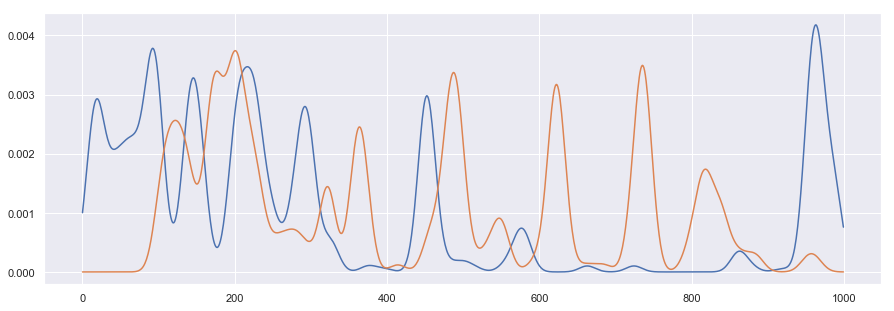

In [30]:
PLOTS.loc['joe'].plot(**FIG)
PLOTS.loc['havisham'].plot(**FIG)

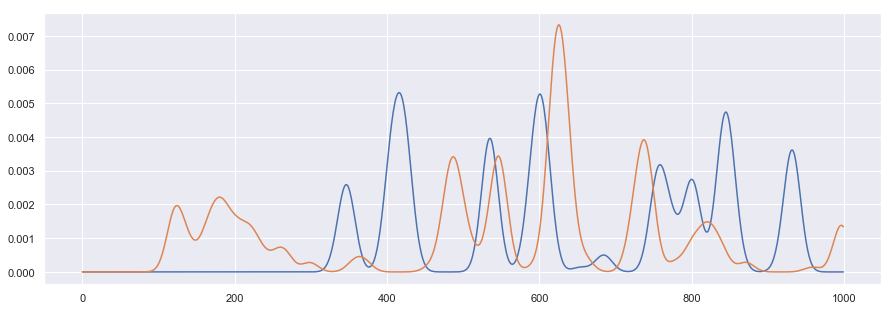

In [46]:
PLOTS.loc['wemmick'].plot(**FIG)
PLOTS.loc['estella'].plot(**FIG)

### Score pairs

In [31]:
pairs = pd.DataFrame([(x,y) for x in B.index for y in B.index if y > x] , columns=['x','y'])

### Compute overlap

In [32]:
def overlap(row):
    kde1 = PLOTS.loc[row.x]
    kde2 = PLOTS.loc[row.y]
    overlap = np.minimum(kde1, kde2)
    return np.trapz(overlap)

In [33]:
pairs['overlap'] = pairs.apply(overlap, axis=1)

In [34]:
def paircorr(row):
    return PLOTS.T[[row.x,row.y]].corr().values[0][1]

In [36]:
pairs['corr'] = pairs.apply(paircorr, axis=1)

### Skim Top Pairs

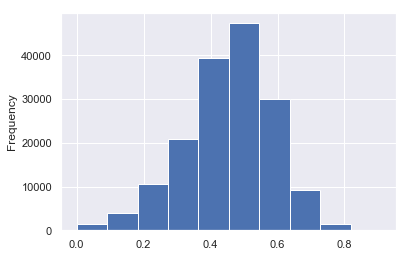

In [37]:
pairs.overlap.plot.hist()

In [38]:
pairs2 = pairs.copy().rename(columns={'x':'y', 'y':'x'})
pairs3 = pd.concat([pairs, pairs2], sort=True)

### Explore term correlations

In [39]:
CORR = pd.crosstab(pairs3.x, pairs3.y, pairs3.overlap, aggfunc='sum').fillna(1)

In [40]:
def corr_plot_terms(terms, dtm, title='Foo'):
    plt.figure(figsize = (20,20))
    print(title)
    corr = dtm[terms].corr()
    sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})
    plt.show()

TEST


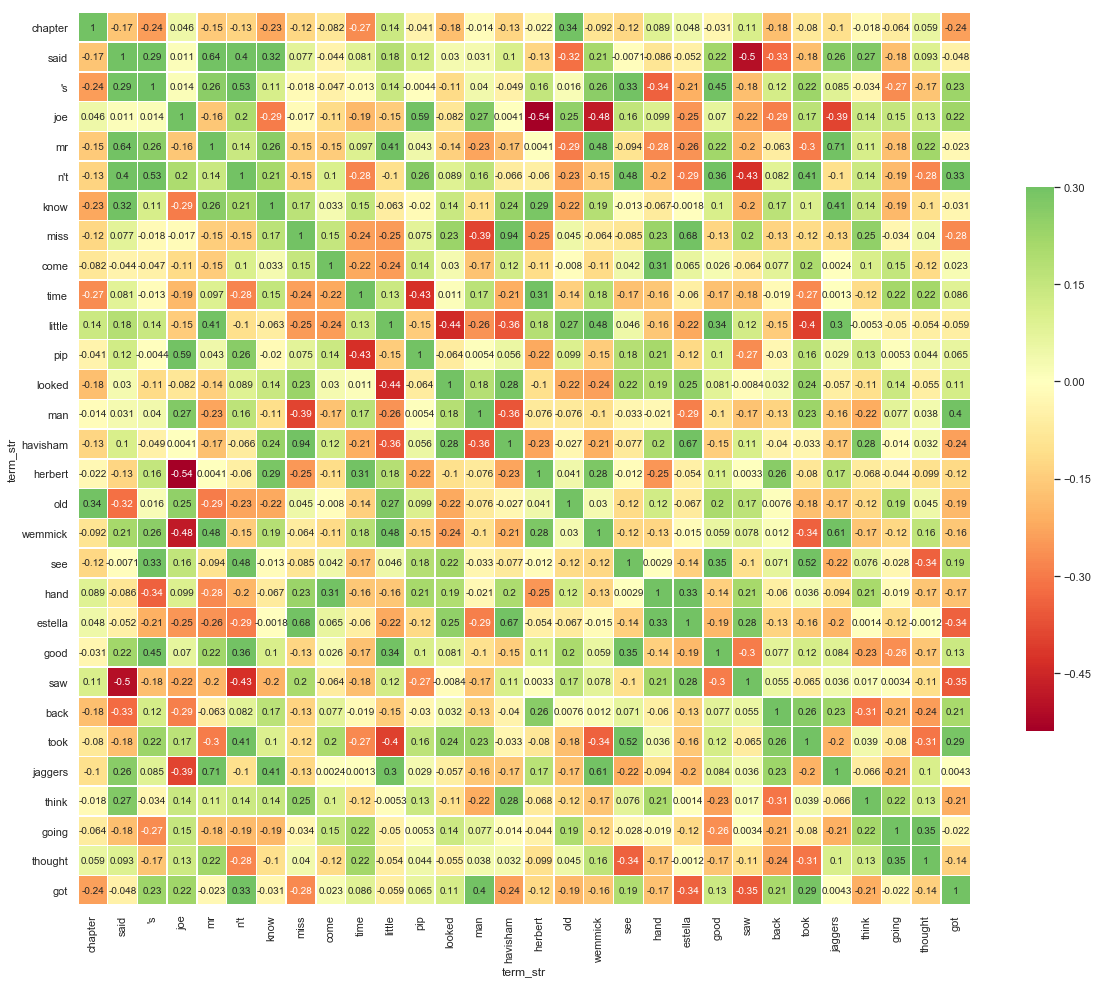

In [41]:
corr_plot_terms(TOP_TERMS, PLOTS.T, title='TEST')

### Export Graphs

In [42]:
import networkx as nx
G = nx.Graph()
edges = pairs[['x','y','overlap']].sort_values('overlap', ascending=False).head(1000).apply(lambda x: (x.x, x.y, x.overlap), axis=1).values
G.add_weighted_edges_from(edges)
nx.write_gexf(G, "{}.gexf".format(slug))

![alt text](GE.png)